In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [ ]:
!pip install xgboost==1.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, make_scorer, f1_score
from imblearn.pipeline import Pipeline
import shap
from datetime import datetime
import json

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
random_seed = 4

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=21)

In [ ]:
auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)

In [ ]:
data_2019 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합/promotion_mind_19.xlsx', engine='openpyxl')
data_2020 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합/promotion_mind_20.xlsx', engine='openpyxl')
data_2021 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합/promotion_mind_21.xlsx', engine='openpyxl')
data_2022 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/NH_1118/promotion_mind_22.xlsx', engine='openpyxl')

preprocessing

In [ ]:
data_2019 = data_2019.loc[data_2019['승진대상 후보여부']=='Yes']
data_2020 = data_2020.loc[data_2020['승진대상 후보여부']=='Yes']
data_2021 = data_2021.loc[data_2021['승진대상 후보여부']=='Yes']
data_2022 = data_2022.loc[data_2022['승진대상 후보여부']=='Yes'].reset_index(drop=True)

In [ ]:
print(len(data_2019))
print(len(data_2020))
print(len(data_2021))
print(len(data_2022))

38
64
69
63


In [ ]:
# 수정
train = pd.concat([data_2019, data_2020, data_2021], axis=0).reset_index(drop=True)

In [ ]:
# 추가
train_data = train.copy()
inf_data = data_2022.copy()

In [ ]:
# val_data = data_2020.copy()

In [ ]:
train_data =train_data.reset_index(drop=True)
inf_data =inf_data.reset_index(drop=True)

In [ ]:
train_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급'], axis=1, inplace=True)

In [ ]:
# 수정 1118-1
inf_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '입사현황'], axis=1, inplace=True)

In [ ]:
# 추가
train_data['셀 참여횟수'] = train_data['셀 참여횟수'].fillna(0)
train_data['봉사활동 참여횟수'] = train_data['봉사활동 참여횟수'].fillna(0)
train_data['평균 교육점수'] = train_data['평균 교육점수'].replace('미신청', 0)
train_data['평균 교육점수'] = train_data['평균 교육점수'].replace('미입사', 0)
train_data['교육 이수여부'] = train_data['교육 이수여부'].replace('미입사', '미신청')
train_data['승진여부'] = train_data['승진여부'].replace({'Yes': 1, 'No':0, '미대상' : 0})

In [ ]:
# 추가
inf_data['셀 참여횟수'] = inf_data['셀 참여횟수'].fillna(0)
inf_data['봉사활동 참여횟수'] = inf_data['봉사활동 참여횟수'].fillna(0)
inf_data['평균 교육점수'] = inf_data['평균 교육점수'].replace('미신청', 0)
inf_data['평균 교육점수'] = inf_data['평균 교육점수'].replace('미입사', 0)
inf_data['교육 이수여부'] = inf_data['교육 이수여부'].replace('미입사', '미신청')

In [ ]:
grade_list = ['당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']

for column in grade_list : 
  for i in range(len(train_data)) : 
    if train_data[column][i] == 'S' :
      train_data[column][i] = 5
    elif train_data[column][i] == 'A' :
      train_data[column][i] = 4
    elif train_data[column][i] == 'B' :
      train_data[column][i] = 3
    elif train_data[column][i] == 'C' :
      train_data[column][i] = 2
    elif train_data[column][i] == 'D' :
      train_data[column][i] = 1
    else : 
      train_data[column][i] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
grade_list = ['당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']

for column in grade_list : 
  for i in range(len(inf_data)) : 
    if inf_data[column][i] == 'S' :
      inf_data[column][i] = 5
    elif inf_data[column][i] == 'A' :
      inf_data[column][i] = 4
    elif inf_data[column][i] == 'B' :
      inf_data[column][i] = 3
    elif inf_data[column][i] == 'C' :
      inf_data[column][i] = 2
    elif inf_data[column][i] == 'D' :
      inf_data[column][i] = 1
    else : 
      inf_data[column][i] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
train_data['승진적합 산출점수'] = train_data['당년 역량평가등급']*0.25 + train_data['당년 업적평가등급']*0.25 + train_data['역량평가등급(1년전)']*0.15 + train_data['업적평가등급(1년전)']*0.15 + train_data['역량평가등급(2년전)']*0.1 + train_data['업적평가등급(2년전)'] * 0.1
for i in range(len(train_data)) : 
  if train_data['교육 이수여부'][i] == 'Yes' : 
    train_data['승진적합 산출점수'][i] = train_data['승진적합 산출점수'][i]*1.05


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
inf_data['승진적합 산출점수'] = inf_data['당년 역량평가등급']*0.25 + inf_data['당년 업적평가등급']*0.25 + inf_data['역량평가등급(1년전)']*0.15 + inf_data['업적평가등급(1년전)']*0.15 + inf_data['역량평가등급(2년전)']*0.1 + inf_data['업적평가등급(2년전)'] * 0.1
for i in range(len(inf_data)) : 
  if inf_data['교육 이수여부'][i] == 'Yes' : 
    inf_data['승진적합 산출점수'][i] = inf_data['승진적합 산출점수'][i]*1.05


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_data = train_data.dropna(axis=0)

In [ ]:
# 추가
pre_all_train = train_data.copy()
pre_all_inf = inf_data.copy()

In [ ]:
'''
per_list = train_data.columns[27:-1].tolist()

train_data = train_data.reset_index(drop=True)
for name in per_list : 
  for i in range(len(train_data)) : 
    if train_data[name][i] <= 50 : 
      train_data[name][i] = 1
    elif train_data[name][i] > 80 : 
      train_data[name][i] = 3
    else : 
      train_data[name][i] = 2
'''

'\nper_list = train_data.columns[27:-1].tolist()\n\ntrain_data = train_data.reset_index(drop=True)\nfor name in per_list : \n  for i in range(len(train_data)) : \n    if train_data[name][i] <= 50 : \n      train_data[name][i] = 1\n    elif train_data[name][i] > 80 : \n      train_data[name][i] = 3\n    else : \n      train_data[name][i] = 2\n'

In [ ]:
# 추가 1117
train_data = train_data.reset_index(drop=True)

In [ ]:
# 수정 1117
personal = ['긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']

for name in personal : 
  sorting = train_data[name].sort_values(ascending=False)
  for i in range(len(train_data)) : 
    train_data[name][sorting.index[i]] = round(i/len(train_data)*100)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# 추가 1117
for name in personal : 
  for i in range(len(train_data)) : 
    if train_data[name][i] <= 5 : 
      train_data[name][i] = 7
    elif train_data[name][i] <=15 : 
      train_data[name][i] = 6
    elif train_data[name][i] <=35 : 
      train_data[name][i] = 5
    elif train_data[name][i] <=60 : 
      train_data[name][i] = 4
    elif train_data[name][i] <=85 : 
      train_data[name][i] = 3
    elif train_data[name][i] <=95 : 
      train_data[name][i] = 2
    elif train_data[name][i] <=100 : 
      train_data[name][i] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

modeling

In [ ]:
# 수정 1117
X = pd.get_dummies(train_data.drop(['사번', '승진여부', '승진대상 후보여부', '연령'], axis=1), columns=['직책', '성별', '입사경로', '학력', '거주지', '교육 이수여부', '전공'], drop_first=True)
X['직책_사무국장'] = 0
X['직책_지부장'] = 0
X['직책_지점장'] = 0 
X['직책_출장소장'] = 0
X = X.astype('float')
y = train_data['승진여부']
y = y.astype('float') 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
sm = SMOTE(random_state=15, k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
benchmark = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Recall', 'Precision', 'AUC'])

for algorithm in [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(random_state=random_seed), DecisionTreeClassifier(random_state=random_seed), 
                 AdaBoostClassifier(random_state=random_seed), XGBClassifier(random_state=random_seed), MLPClassifier(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['classifier', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= auc_scorer,
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_res, y_res)
    results_pred = results.predict(X_test)
    acc = accuracy_score(y_test, results_pred)
    recall = recall_score(y_test, results_pred)
    pre = precision_score(y_test, results_pred)
    auc = roc_auc_score(y_test, results_pred)
    benchmark = benchmark.append({'Algorithm' : algorithm, 'Accuracy' : acc,'Recall' : recall, 'Precision' : pre, 'AUC' : auc}, ignore_index=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [ ]:
benchmark

,Algorithm,Accuracy,Recall,Precision,AUC
0,LogisticRegression(),0.545455,0.222222,0.400000,0.495726
1,KNeighborsClassifier(),0.545455,0.555556,0.454545,0.547009
2,SVC(),0.613636,0.722222,0.520000,0.630342
3,RandomForestClassifier(random_state=4),0.477273,0.277778,0.333333,0.446581
4,DecisionTreeClassifier(random_state=4),0.522727,0.333333,0.400000,0.493590
5,AdaBoostClassifier(random_state=4),0.545455,0.222222,0.400000,0.495726
6,"XGBClassifier(base_score=None, booster=None, c...",0.522727,0.333333,0.400000,0.493590
7,MLPClassifier(random_state=4),0.613636,0.500000,0.529412,0.596154


In [ ]:
opt_dict = {}
idx = benchmark['AUC'].idxmax()
column_list = ['Accuracy', 'Recall', 'Precision', 'AUC']
benchmark = benchmark.drop([idx], axis=0).reset_index(drop=True) 

for columns in list(column_list) : 
  opt_dict['Average '+columns] = benchmark[columns].mean()

opt_dict  

{'Average Accuracy': 0.538961038961039,
 'Average Recall': 0.34920634920634924,
 'Average Precision': 0.4167557932263814,
 'Average AUC': 0.5097680097680097}

In [ ]:
'''
max = 0
seed_number_rf = 0
rf_number = 0

for seed in range(0, 50) : 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify= y)
  for num in range(0, 50) : 
    sm = SMOTE(random_state=num, k_neighbors=5)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    model_rf = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)
    model_rf.fit(X_res, y_res)
    pred_rf = model_rf.predict(X_test)
    auc = roc_auc_score(y_test, pred_rf)
    if auc > max :
      max = auc
      seed_number_rf = seed
      rf_number = num
print(max)
print(seed_number_rf)
print(rf_number)
'''

'\nmax = 0\nseed_number_rf = 0\nrf_number = 0\n\nfor seed in range(0, 50) : \n  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify= y)\n  for num in range(0, 50) : \n    sm = SMOTE(random_state=num, k_neighbors=5)\n    X_res, y_res = sm.fit_resample(X_train, y_train)\n    model_rf = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)\n    model_rf.fit(X_res, y_res)\n    pred_rf = model_rf.predict(X_test)\n    auc = roc_auc_score(y_test, pred_rf)\n    if auc > max :\n      max = auc\n      seed_number_rf = seed\n      rf_number = num\nprint(max)\nprint(seed_number_rf)\nprint(rf_number)\n'

In [ ]:
# 수정 1114
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify= y)
pipeline_xgb = Pipeline(steps=[('smote', SMOTE(random_state=7)), ('classifier', XGBClassifier(random_state=0))])


params_xgb={'smote__k_neighbors' : [5],
            'classifier__n_estimators' : [100],
            'classifier__max_depth' : [10]}


grid_search_xgb = GridSearchCV(estimator=pipeline_xgb,
                               param_grid=params_xgb,
                               cv = stratified_kfold,
                               scoring = auc_scorer,
                               n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)
pred_xgb = grid_search_xgb.predict(X_test)
pred_proba = grid_search_xgb.predict_proba(X_test)[:,1]
print(grid_search_xgb.best_params_)
now = datetime.now()

acc = accuracy_score(y_test, pred_xgb)
re = recall_score(y_test, pred_xgb)
pre = precision_score(y_test, pred_xgb)
f1 = f1_score(y_test, pred_xgb)
auc = roc_auc_score(y_test, pred_xgb)

metrics_dict = {}
metrics_dict['accuracy_score'] = acc
metrics_dict['recall_score'] = re
metrics_dict['precision_score'] = pre
metrics_dict['f1_score'] = f1
metrics_dict['AUC'] = auc

metrics_dict

{'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'smote__k_neighbors': 5}


{'accuracy_score': 0.7586206896551724,
 'recall_score': 0.75,
 'precision_score': 0.6923076923076923,
 'f1_score': 0.7199999999999999,
 'AUC': 0.7573529411764706}

In [ ]:
end_model = grid_search_xgb.best_estimator_['classifier']

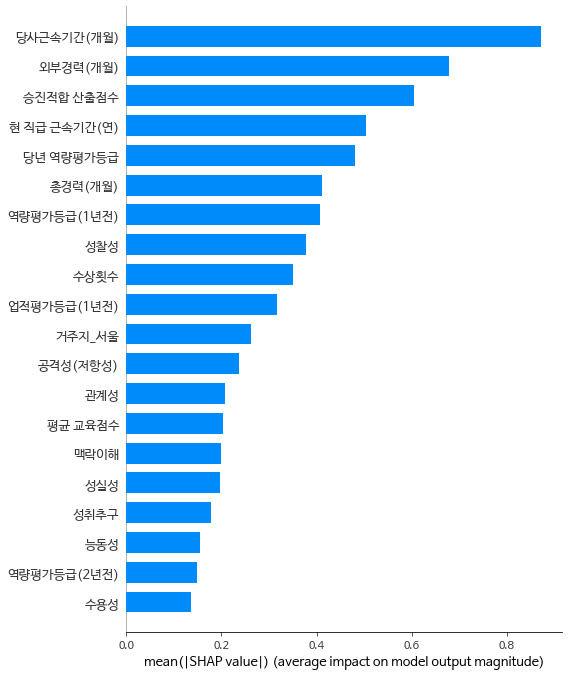

In [ ]:
explainer = shap.explainers.Tree(end_model, X_train) # 수정
shap_values = explainer.shap_values(X_test) 
shap_obj = explainer(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [ ]:
importances = np.absolute(shap_values).sum(axis=0) / shap_values.shape[0]
feature_importance = pd.Series(importances / sum(importances))
feature_importance.index = X_train.columns

In [ ]:
# 수정 1117
numerical = ['당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '현 직급 근속기간(연)', '이직횟수', '셀 참여횟수', '봉사활동 참여횟수', 
       '직무관련자격증', '수상횟수', '평균 교육점수', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)',
       '업적평가등급(1년전)', '업적평가등급(2년전)', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정',
       '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식',
       '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성',
       '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균', '승진적합 산출점수']
categorical = ['직책', '성별', '입사경로', '학력', '거주지', '교육 이수여부', '전공'] 
fe_list = list(feature_importance.index)

In [ ]:
cat_imp = []
for name in categorical : 
  sum = 0
  for i in range (len(fe_list)) : 
    if name in fe_list[i] :
      sum += feature_importance[i]
  cat_imp.append(sum)

In [ ]:
cat_fe = pd.Series(cat_imp)
cat_fe.index = categorical

In [ ]:
nu_fe = feature_importance[numerical]

In [ ]:
result_fe = pd.concat([nu_fe, cat_fe])

In [ ]:
# 수정 11130

result_fe['승진적합 산출점수'] += result_fe['당사근속기간(개월)']*0.4
result_fe['당년 역량평가등급'] += result_fe['당사근속기간(개월)']*0.4
result_fe['당사근속기간(개월)'] = result_fe['당사근속기간(개월)']*0.2

result_fe['당년 업적평가등급'] += result_fe['외부경력(개월)']*0.9
result_fe['외부경력(개월)'] = result_fe['외부경력(개월)']*0.1

result_fe['역량평가등급(2년전)'] += result_fe['현 직급 근속기간(연)']*0.5
result_fe['셀 참여횟수'] += result_fe['현 직급 근속기간(연)']*0.3
result_fe['현 직급 근속기간(연)'] = result_fe['현 직급 근속기간(연)']*0.2
result_fe['업적평가등급(2년전)'] += result_fe['총경력(개월)']*0.4
result_fe['봉사활동 참여횟수'] += result_fe['총경력(개월)']*0.3
result_fe['수상횟수'] += result_fe['총경력(개월)']*0.1
result_fe['총경력(개월)'] = result_fe['총경력(개월)']*0.2
'''
result_fe['셀 참여횟수'] += result_fe['수상횟수']*0.4
result_fe['봉사활동 참여횟수'] += result_fe['수상횟수']*0.4
result_fe['수상횟수'] = result_fe['수상횟수']*0.2
'''
result_fe['셀 참여횟수'] += result_fe['거주지']*0.4
result_fe['봉사활동 참여횟수'] += result_fe['거주지']*0.4
result_fe['거주지'] = result_fe['거주지']*0.2
###
result_fe['징계횟수'] = result_fe['수상횟수']
###

In [ ]:
fe_dict = result_fe.to_dict()

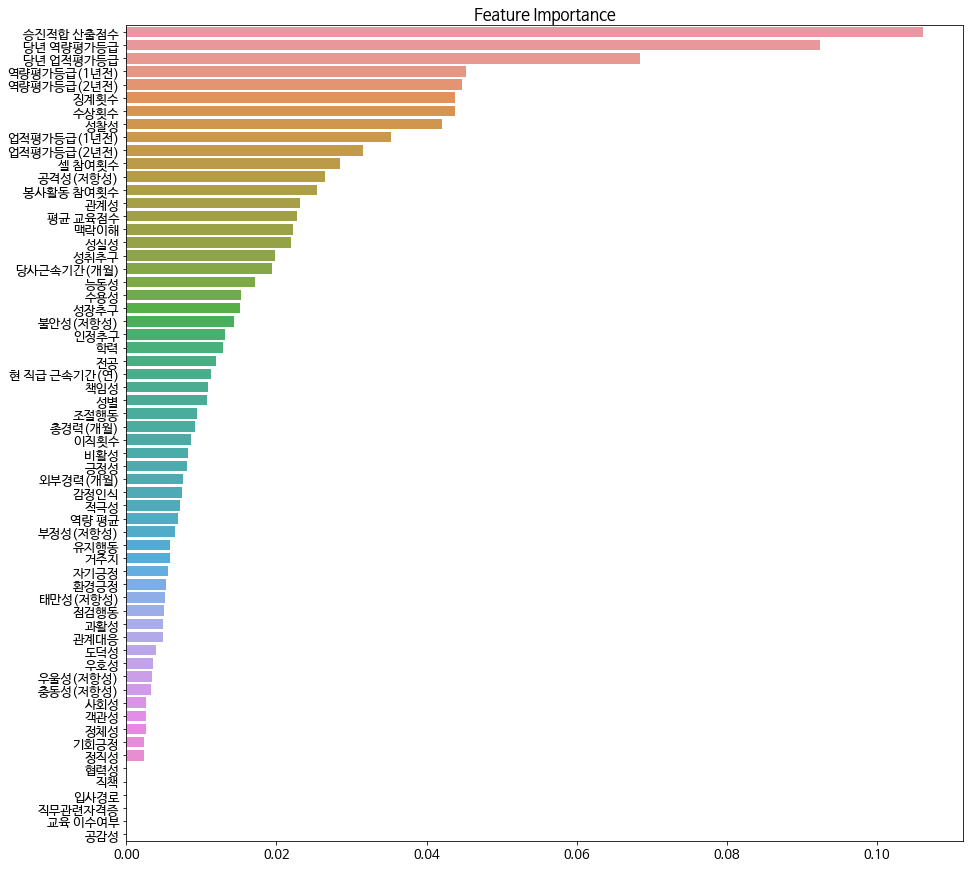

In [ ]:
import seaborn as sns

ft_importance = result_fe.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=13)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

In [ ]:
rr = shap_obj.abs.max(0).values
new_series = pd.Series(rr, index=X_test.columns.tolist())

In [ ]:
cate = new_series.copy()

In [ ]:
rr = shap_obj.abs.max(0).values
new_series = pd.Series(rr, index=X_test.columns.tolist())

for i in range(len(result_fe)) : 
  if result_fe.index[i] in new_series.index.tolist() : 
    new_series[result_fe.index[i]] = result_fe.values[i]

for i in range(len(new_series)) : 
  if new_series.index[i] not in result_fe.index.tolist() : 
    new_series[new_series.index[i]] = 0

In [ ]:
qwe = explainer(X_test)
qwe.values = new_series.values

In [ ]:
# shap.plots.beeswarm(shap_obj, max_display=30, order=qwe)

In [ ]:
cate[54:]

직책_팀원          0.000000
직책_팀장          0.000000
성별_여자          0.567910
입사경로_신입        0.000000
학력_대졸          0.319709
학력_대학원졸        0.135999
학력_전졸          0.102629
거주지_광주         0.000000
거주지_대구         0.000000
거주지_대전         0.000000
거주지_부산         0.000000
거주지_서울         0.589519
거주지_인천         0.000000
거주지_충북         0.000000
교육 이수여부_미신청    0.000000
전공_공학계열        0.000000
전공_교육계열        0.000000
전공_사회계열        0.086125
전공_예체능계열       0.000000
전공_인문계열        0.000000
전공_자연계열        0.227200
직책_사무국장        0.000000
직책_지부장         0.000000
직책_지점장         0.000000
직책_출장소장        0.000000
dtype: float64

In [ ]:
# 수정 1117
pos_max = shap_values.max(axis=0)
neg_max = shap_values.min(axis=0)
new_list = []
for row in shap_values:
  temp = []
  for ele, pos, neg in zip(row, pos_max, neg_max):
    if ele >= 0:
      if pos == 0: 
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list.append(temp)

fw = pd.DataFrame(new_list, index = pd.RangeIndex(len(shap_values)), columns = X_test.columns)
fw = fw.fillna(0)

In [ ]:
for name in fw.columns.tolist() : 
  if name not in numerical : 
    fw[name] = 0

In [ ]:
X_test = X_test.reset_index(drop=True)

fw['봉사활동 참여횟수'] = X_test['봉사활동 참여횟수']*0.1
fw['셀 참여횟수'] = X_test['셀 참여횟수']*0.1

fw['당사근속기간(개월)'] = fw['당사근속기간(개월)']*0.5
fw['외부경력(개월)'] = fw['외부경력(개월)']*0.5
fw['현 직급 근속기간(연)'] = fw['현 직급 근속기간(연)']*0.5

In [ ]:
main_dict = {}
main_dict['feature importance'] = fe_dict
main_dict['trainset_size'] = len(X_train)
main_dict['testset_size'] = len(X_test)
main_dict['total_size'] = len(X_train)+len(X_test)
main_dict['last_train_date'] = str(now)
main_dict['prediction'] = dict()

In [ ]:
for cutoff in np.arange(.05, 1., .05) :
  sum = 0
  for k in pred_proba : 
    if k>= cutoff :
      sum += 1
  main_dict['prediction'][cutoff] = sum

In [ ]:
main_dict['metrics'] = metrics_dict
main_dict['algorithm others'] = opt_dict

In [ ]:
# 수정 1117
missing_rate = {}
feature_data = train[['직책', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '현 직급 근속기간(연)', '이직횟수',
       '입사경로', '학력', '전공', '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '평균 교육점수',
       '교육 이수여부', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정',
       '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식',
       '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성',
       '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']]  # column 명칭 수정

for name in feature_data.columns.tolist() : 
  cnt = 0
  for i in range(len(feature_data)) : 
    if feature_data[name].isnull()[i] == True : 
      cnt+=1
    elif feature_data[name][i]=='미입사' : 
      cnt+=1
    elif feature_data[name][i]=='미평가' : 
      cnt+=1
  missing_rate[name] = cnt
missing_rate['all'] = len(feature_data) 

In [ ]:
missing_file_path = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/missing_rate_승진적합(다면평가).json'

with open(missing_file_path, 'r') as f:
    json_data = json.load(f)

In [ ]:
# 수정 1117
missing_rate_all = {}

same_json = ['직책', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '현 직급 근속기간(연)', '이직횟수', '입사경로', '학력', '전공', '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '평균 교육점수', '교육 이수여부', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']
segment = ['전문성_평균평점', '리더십_평균평점', '부하육성_평균평점', '관계관리_평균평점', '조직비전_평균평점', '직책수행능력_평균평점', '조직내 필요성_평균평점', '동반자 의식_평균평점', '직책수행능력', '조직내 필요성', '동반자 의식']
personal = ['긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정', '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식', '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성', '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균']

for name in same_json : 
  missing_rate_all[name] = (missing_rate[name]+json_data[name])/(missing_rate['all']+json_data['all'])

for name in segment : 
  missing_rate_all[name] = json_data[name]/(missing_rate['all']+json_data['all'])

for name in personal : 
  missing_rate_all[name] = missing_rate[name]/(missing_rate['all']+json_data['all'])  

In [ ]:
# 추가
main_dict['feature missing rate'] = missing_rate_all

In [ ]:
main_dict

{'feature importance': {'당사근속기간(개월)': 0.019430421854660908,
  '외부경력(개월)': 0.007569068519583827,
  '총경력(개월)': 0.009158116344173831,
  '현 직급 근속기간(연)': 0.01124558852259001,
  '이직횟수': 0.008678888659330562,
  '셀 참여횟수': 0.02850890243723644,
  '봉사활동 참여횟수': 0.02537769416961217,
  '직무관련자격증': 0.0,
  '수상횟수': 0.043751498617566914,
  '평균 교육점수': 0.022751136563846138,
  '당년 역량평가등급': 0.09238502404850052,
  '당년 업적평가등급': 0.0684065559196761,
  '역량평가등급(1년전)': 0.04527736452558569,
  '역량평가등급(2년전)': 0.04466301272696735,
  '업적평가등급(1년전)': 0.0352770654609195,
  '업적평가등급(2년전)': 0.03146267177834659,
  '긍정성': 0.008105933816362782,
  '적극성': 0.007093970792317631,
  '성실성': 0.021926908674659424,
  '사회성': 0.0026444453280703526,
  '정체성': 0.002563555489473852,
  '관계성': 0.023160223918146938,
  '객관성': 0.002608888387859464,
  '비활성': 0.008240247018016518,
  '과활성': 0.004917755289568133,
  '자기긍정': 0.005516819594386629,
  '기회긍정': 0.0023748783210308477,
  '환경긍정': 0.0053440269792678725,
  '성취추구': 0.01975399212640245,
  '인정추구': 0.0

In [ ]:
json_file = json.dumps(main_dict)

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합_v2/승진적합_인적성.json'

In [ ]:
with open(file_path, 'w', encoding='utf-8-sig') as file:
    file.write(json.dumps(main_dict, ensure_ascii=False))

Inference

In [ ]:
# 수정 1117
inf_x = pd.get_dummies(inf_data.drop(['사번', '승진대상 후보여부', '연령'], axis=1), columns=['직책', '성별', '입사경로', '학력', '거주지', '교육 이수여부', '전공'], drop_first=True)

inf_x['거주지_충북'] = 0
inf_x['전공_교육계열'] = 0

inf_x = inf_x[X_train.columns]
inf_x = inf_x.astype('float')

In [ ]:
# 추가 1117
for name in personal : 
  sorting = inf_x[name].sort_values(ascending=False)
  for i in range(len(inf_x)) : 
    inf_x[name][sorting.index[i]] = round(i/len(inf_x)*100)

In [ ]:
# 추가 1117
for name in personal : 
  for i in range(len(inf_x)) : 
    if inf_x[name][i] <= 5 : 
      inf_x[name][i] = 7
    elif inf_x[name][i] <=15 : 
      inf_x[name][i] = 6
    elif inf_x[name][i] <=35 : 
      inf_x[name][i] = 5
    elif inf_x[name][i] <=60 : 
      inf_x[name][i] = 4
    elif inf_x[name][i] <=85 : 
      inf_x[name][i] = 3
    elif inf_x[name][i] <=95 : 
      inf_x[name][i] = 2
    elif inf_x[name][i] <=100 : 
      inf_x[name][i] = 1

In [ ]:
'''
inf_x = inf_x.reset_index(drop=True)
for name in per_list : 
  for i in range(len(inf_x)) : 
    if inf_x[name][i] <= 50 : 
      inf_x[name][i] = 1
    elif inf_x[name][i] > 80 : 
      inf_x[name][i] = 3
    else : 
      inf_x[name][i] = 2
'''

'\ninf_x = inf_x.reset_index(drop=True)\nfor name in per_list : \n  for i in range(len(inf_x)) : \n    if inf_x[name][i] <= 50 : \n      inf_x[name][i] = 1\n    elif inf_x[name][i] > 80 : \n      inf_x[name][i] = 3\n    else : \n      inf_x[name][i] = 2\n'

In [ ]:
pred = end_model.predict(inf_x)
inf_proba = end_model.predict_proba(inf_x)[:,1]

In [ ]:
result = pd.DataFrame(columns=['승진여부'])
result['승진여부'] = pred
result['predict_proba'] = inf_proba

In [ ]:
result['승진여부'] = result['승진여부'].replace(0, '유지')
result['승진여부'] = result['승진여부'].replace(1, '승진')

In [ ]:
final_result = pd.concat([inf_data, result], axis=1)

In [ ]:
final_result['수상횟수'] = final_result['수상횟수'].astype('float')

In [ ]:
# 수정 1124
for i in range(len(final_result)) : 
  if final_result['predict_proba'][i] < 0.5 : 
    if (final_result['셀 참여횟수'][i]!=0 and final_result['봉사활동 참여횟수'][i]!=0) : 
      final_result['predict_proba'][i] = final_result['predict_proba'][i] + final_result['셀 참여횟수'][i]*0.08 + final_result['봉사활동 참여횟수'][i]*0.08 + 0.05
    else : 
      final_result['predict_proba'][i] = final_result['predict_proba'][i] + final_result['셀 참여횟수'][i]*0.08 + final_result['봉사활동 참여횟수'][i]*0.08

for i in range(len(final_result)) :
  if (final_result['predict_proba'][i] + final_result['수상횟수'][i]*0.04) < 1 : 
    final_result['predict_proba'][i] = final_result['predict_proba'][i] + final_result['수상횟수'][i]*0.04

punish_list = ['B1210011', 'B1110035', 'B1110036', 'B1110058', 'B1110077', 'B1510023', 'B1510062', 'B1210021', 'B1210076']
punish_data = []
for i in range(len(final_result)) : 
  if final_result['사번'][i] in punish_list : 
    punish_data.append(1)
  elif final_result['사번'][i] == 'B1310064' : 
    punish_data.append(2)
  else : 
    punish_data.append(0)

for i in range(len(final_result)) :
  if (final_result['predict_proba'][i] - punish_data[i]*0.04) > 0 : 
    final_result['predict_proba'][i] = final_result['predict_proba'][i] - punish_data[i]*0.04
  elif (final_result['predict_proba'][i] - punish_data[i]*0.04) < 0 : 
    final_result['predict_proba'][i] = 0

for i in range(len(final_result)) : 
  if final_result['predict_proba'][i] >=0.5 : 
    final_result['승진여부'][i] = '승진'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
# 수정 1118-1
private_feature = ['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '입사현황']
for name in private_feature : 
  final_result = final_result.join(data_2022.set_index('사번')[name], on='사번')

In [ ]:
# 수정 1118-1
final_result = final_result[['사번', '성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '입사현황', '직책', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '현 직급 근속기간(연)', '이직횟수',
       '입사경로', '학력', '전공', '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '평균 교육점수',
       '교육 이수여부', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)', '긍정성', '적극성', '성실성', '사회성', '정체성', '관계성', '객관성', '비활성', '과활성', '자기긍정',
       '기회긍정', '환경긍정', '성취추구', '인정추구', '성장추구', '점검행동', '조절행동', '유지행동', '감정인식',
       '맥락이해', '관계대응', '성찰성', '수용성', '능동성', '공감성', '우호성', '협력성', '도덕성', '정직성',
       '책임성', '우울성(저항성)', '부정성(저항성)', '태만성(저항성)', '불안성(저항성)', '충동성(저항성)',
       '공격성(저항성)', '역량 평균', '승진적합 산출점수', '승진여부', 'predict_proba']]  # column 명칭 수정

In [ ]:
# 추가 3년치 평가등급 보여주기
final_result[['평균 교육점수', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']] = data_2022[['평균 교육점수', '당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']]

In [ ]:
shap_values_inf = explainer.shap_values(inf_x) 

In [ ]:
# 수정 1117
pos_max = shap_values_inf.max(axis=0)
neg_max = shap_values_inf.min(axis=0)
new_list = []
for row in shap_values_inf:
  temp = []
  for ele, pos, neg in zip(row, pos_max, neg_max):
    if ele >= 0:
      if pos == 0: 
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list.append(temp)

feature_weight = pd.DataFrame(shap_values_inf, index = pd.RangeIndex(len(shap_values_inf)), columns = X_test.columns)
feature_weight = feature_weight.fillna(0)

In [ ]:
categorical_feature = ['직책', '성별', '입사경로', '학력', '거주지', '교육 이수여부', '전공']
cate_main = []

for i in range(len(feature_weight)) :
  temp_1 = []
  for name in categorical_feature : 
    temp_2 = []
    for j in range (len(feature_weight.columns.tolist())) : 
      if name in feature_weight.columns.tolist()[j] : 
        real_name = feature_weight.columns.tolist()[j]
        temp_2.append(feature_weight[real_name][i])
    data_sum = np.sum(temp_2)
    temp_1.append(data_sum)
  cate_main.append(temp_1)

In [ ]:
# 수정 1114
ttt = pd.DataFrame(cate_main, columns=categorical_feature)

feature_weight.drop(['직책_팀원', '직책_팀장', '성별_여자', '입사경로_신입', '학력_대졸', '학력_대학원졸', '학력_전졸',
       '거주지_광주', '거주지_대구', '거주지_대전', '거주지_부산', '거주지_서울', '거주지_인천', '거주지_충북',
       '교육 이수여부_미신청', '전공_공학계열', '전공_교육계열', '전공_사회계열',
       '전공_예체능계열', '전공_인문계열', '전공_자연계열', '직책_사무국장', '직책_지부장', '직책_지점장',
       '직책_출장소장'], axis=1, inplace=True)
feature_weight = pd.concat([feature_weight, ttt], axis=1)

In [ ]:
mm = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
for i in range (len(feature_weight.max())) : 
  if feature_weight.max()[i] > 1 : 
    feature_name = feature_weight.max().index[i]
    scaling = mm.fit_transform(feature_weight[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight)) : 
      feature_weight[feature_name][j] = scaling[j][0]

for i in range (len(feature_weight.min())) : 
  if feature_weight.min()[i] < -1 : 
    feature_name = feature_weight.min().index[i]
    scaling = mm.fit_transform(feature_weight[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight)) : 
      feature_weight[feature_name][j] = scaling[j][0]

In [ ]:
feature_weight.insert(0, '사번', inf_data['사번'].tolist())

In [ ]:
# 수정 1117

feature_weight['봉사활동 참여횟수'] = final_result['봉사활동 참여횟수']*0.1
feature_weight['셀 참여횟수'] = final_result['셀 참여횟수']*0.1

feature_weight['당사근속기간(개월)'] = feature_weight['당사근속기간(개월)']*0.5
feature_weight['외부경력(개월)'] = feature_weight['외부경력(개월)']*0.5
feature_weight['현 직급 근속기간(연)'] = feature_weight['현 직급 근속기간(연)']*0.5

In [ ]:
feature_weight.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합_v2/feature_weight_승진적합_인적성.csv', encoding='utf-8-sig', index=False)

In [ ]:
# 수정 1116
attrition = ['정희진', '박영민', '강도이', '박상완']
attrition_idx = []
for i in range(len(final_result)) : 
 if final_result['성명'][i] in attrition : 
   attrition_idx.append(i)

final_result.drop(attrition_idx, inplace=True)

In [ ]:
# 수정 1107
final_result.drop(final_result.loc[final_result['직급']=='부장'][final_result.loc[final_result['직급']=='부장']['현 직급 근속기간(연)']<3].index.tolist(), inplace=True)

In [ ]:
# 수정 1110
final_result.drop(final_result.loc[final_result['직급']=='이사대우'].index.tolist(), inplace=True)
final_result.drop(final_result.loc[final_result['직급']=='기획역'].index.tolist(), inplace=True)

In [ ]:
# 수정 1107
final_result.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)

In [ ]:
final_result
final_result.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/승진적합_v2/output_승진적합_인적성.csv', encoding='utf-8-sig', index=False)

In [ ]:
qwer = final_result.dropna(subset=['역량 평균'], axis=0)
qqqq = qwer[numerical]
qqqq['predict_proba'] = qwer['predict_proba']
qqqq = qqqq.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
grade_list = ['당년 역량평가등급', '당년 업적평가등급', '역량평가등급(1년전)', '역량평가등급(2년전)', '업적평가등급(1년전)', '업적평가등급(2년전)']

for column in grade_list : 
  for i in range(len(qqqq)) : 
    if qqqq[column][i] == 'S' :
      qqqq[column][i] = 5
    elif qqqq[column][i] == 'A' :
      qqqq[column][i] = 4
    elif qqqq[column][i] == 'B' :
      qqqq[column][i] = 3
    elif qqqq[column][i] == 'C' :
      qqqq[column][i] = 2
    elif qqqq[column][i] == 'D' :
      qqqq[column][i] = 1
    else : 
      qqqq[column][i] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
qqqq.replace('미신청', 0, inplace=True)
qqqq.replace('미입사', 0, inplace=True)

In [ ]:
qqqq = qqqq.astype('float')

In [ ]:
ffff= qqqq.corr(method='pearson')

In [ ]:
df = pd.DataFrame(ffff['predict_proba'].sort_values(ascending=False), columns=['predict_proba'])
df.style.background_gradient(cmap='viridis')

,predict_proba
predict_proba,1.000000
당년 역량평가등급,0.741592
승진적합 산출점수,0.559593
역량평가등급(1년전),0.495043
당년 업적평가등급,0.384800
봉사활동 참여횟수,0.356082
맥락이해,0.316989
수상횟수,0.290867
업적평가등급(1년전),0.288372
평균 교육점수,0.264379
